<a href="https://colab.research.google.com/github/Shj-A/2022_ML_Project/blob/main/CNN_MNIST_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torchsummary import summary

In [ ]:
train_data = torchvision.datasets.MNIST(
    root = './data/MNIST',
    train = True,
    download = True,
    transform = transforms.Compose([transforms.ToTensor()])
)

test_data = torchvision.datasets.MNIST(
    root = './data/MNIST',
    train = False,
    download = True,
    transform = transforms.Compose([transforms.ToTensor()])
)

train_data, valid_data = train_test_split(train_data, test_size=0.2, shuffle=True)
print('# of train data : {}'.format(len(train_data)))
print('# of valid data : {}'.format(len(valid_data)))
print('# of test data : {}'.format(len(test_data)))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw

# of train data : 48000
# of valid data : 12000
# of test data : 10000


In [ ]:
class CNN_1(nn.Module):
    def __init__(self, n_channel, n_outputs, conv_kernel_size):
        super(CNN_1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=n_channel,
                               out_channels=6,
                               kernel_size=conv_kernel_size,
                               stride=1,
                               padding='same')
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6,
                               out_channels=16,
                               kernel_size=conv_kernel_size,
                               stride=1,
                               padding='same')
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(in_features=16*7*7, out_features=120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, n_outputs)
    
    def forward(self, x):
        x = F.relu(self.conv1(x)) # conv1 -> ReLU
        x = self.pool1(x)
        x = F.relu(self.conv2(x)) # conv2 -> ReLU
        x = self.pool2(x)
        x = x.view(-1, 16*7*7) # flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#1-1 change the current kernel size

In [ ]:
batch_size = 32

n_epochs = 5
learning_rate = 0.01
loss_function = nn.CrossEntropyLoss()

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = False)

In [ ]:
import copy
Kernel = [8,12,16]

for i in Kernel:
    model = CNN_1(1,10,i)
    print(model)
    
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    n_epochs = 10
    train_loss = [] # train loss per epoch
    valid_loss = [] # valid loss per epoch
    
    train_acc = [] # train accuracy per epoch
    valid_acc = [] # valid accuracy per epoch
    
    # update following two variables whenever valid accuracy improves
    best_model = copy.deepcopy(model)
    best_acc = 0
    
    for epoch in range(n_epochs):
        model.train() # set model as training mode(for compute gradient)
        train_total = 0
        train_correct = 0
        epoch_train_loss = 0
        
        for i, data in enumerate(train_loader):
            optimizer.zero_grad()
            
            inputs, labels = data[0], data[1]
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            loss = loss_function(outputs, labels)
            epoch_train_loss += loss.item()
            loss.backward() # compute gradient
            optimizer.step() # update weight & bias in the model with computed gradient
            
        train_loss.append(epoch_train_loss/len(train_loader))
        train_acc.append(train_correct/train_total)
        
        model.eval() # set model as evaluation mode
        with torch.no_grad():# we don't need to compute gradient during the evaluation process
            valid_total = 0
            valid_correct = 0
            epoch_valid_loss = 0
            for data in valid_loader:
                inputs, labels = data[0], data[1]
                outputs = model(inputs)
                
                _, predicted = torch.max(outputs.data, 1)
                valid_total += labels.size(0)
                valid_correct += (predicted == labels).sum().item()
                
                loss = loss_function(outputs, labels)
                epoch_valid_loss += loss.item()
            
            valid_loss.append(epoch_valid_loss/len(valid_loader))
            valid_acc.append(valid_correct / valid_total)
            
        print('[{}/{}]'.format(epoch+1, n_epochs))
        print('training loss : {:.3f}\t training accuracy : {:.3f}'.format(epoch_train_loss/len(train_loader), train_correct/train_total))
        print('validation loss : {:.3f}\t validation accuracy : {:.3f}'.format(epoch_valid_loss/len(valid_loader), valid_correct/valid_total))
        
        if valid_correct/valid_total > best_acc:
            print('validation accuracy improved {:.5f} ======> {:.5f}'.format(best_acc, valid_correct/valid_total))
            best_acc = valid_correct/valid_total
            best_model = copy.deepcopy(model)
    print("-----------------------------------------------------------------------------------------------------")


CNN_1(
  (conv1): Conv2d(1, 6, kernel_size=(8, 8), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(8, 8), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:444: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:744.)
  self.padding, self.dilation, self.groups)


[1/10]
training loss : 0.217	 training accuracy : 0.941
validation loss : 0.163	 validation accuracy : 0.961
validation accuracy improved 0.00000 ======> 0.96100
[2/10]
training loss : 0.153	 training accuracy : 0.964
validation loss : 0.235	 validation accuracy : 0.950
[3/10]
training loss : 0.132	 training accuracy : 0.970
validation loss : 0.115	 validation accuracy : 0.976
validation accuracy improved 0.96100 ======> 0.97600
[4/10]
training loss : 0.130	 training accuracy : 0.972
validation loss : 0.146	 validation accuracy : 0.967
[5/10]
training loss : 0.118	 training accuracy : 0.975
validation loss : 0.144	 validation accuracy : 0.971
[6/10]
training loss : 0.109	 training accuracy : 0.978
validation loss : 0.178	 validation accuracy : 0.967
[7/10]
training loss : 0.139	 training accuracy : 0.973
validation loss : 0.178	 validation accuracy : 0.971
[8/10]
training loss : 0.136	 training accuracy : 0.974
validation loss : 0.204	 validation accuracy : 0.972
[9/10]
training loss :

#1-2 different pooling layer 

In [ ]:
class CNN_2(nn.Module):
    def __init__(self, n_channel, n_outputs, conv_kernel_size):
        super(CNN_2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=n_channel,
                               out_channels=6,
                               kernel_size=conv_kernel_size,
                               stride=1,
                               padding='same')
        self.conv2 = nn.Conv2d(in_channels=6,
                               out_channels=16,
                               kernel_size=conv_kernel_size,
                               stride=1,
                               padding='same')
        self.fc1 = nn.Linear(in_features=16*28*28, out_features=120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, n_outputs)
    
    def forward(self, x):
        x = F.relu(self.conv1(x)) # conv1 -> ReLU
        x = F.relu(self.conv2(x)) # conv2 -> ReLU
        x = x.view(-1, 16*28*28) # flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
Kernel = [8,12,16]

for i in Kernel:
    model = CNN_2(1,10,i)
    print(model)
    
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    n_epochs = 10
    train_loss = [] # train loss per epoch
    valid_loss = [] # valid loss per epoch
    
    train_acc = [] # train accuracy per epoch
    valid_acc = [] # valid accuracy per epoch
    
    # update following two variables whenever valid accuracy improves
    best_model = copy.deepcopy(model)
    best_acc = 0
    
    for epoch in range(n_epochs):
        model.train() # set model as training mode(for compute gradient)
        train_total = 0
        train_correct = 0
        epoch_train_loss = 0
        
        for i, data in enumerate(train_loader):
            optimizer.zero_grad()
            
            inputs, labels = data[0], data[1]
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            loss = loss_function(outputs, labels)
            epoch_train_loss += loss.item()
            loss.backward() # compute gradient
            optimizer.step() # update weight & bias in the model with computed gradient
            
        train_loss.append(epoch_train_loss/len(train_loader))
        train_acc.append(train_correct/train_total)
        
        model.eval() # set model as evaluation mode
        with torch.no_grad():# we don't need to compute gradient during the evaluation process
            valid_total = 0
            valid_correct = 0
            epoch_valid_loss = 0
            for data in valid_loader:
                inputs, labels = data[0], data[1]
                outputs = model(inputs)
                
                _, predicted = torch.max(outputs.data, 1)
                valid_total += labels.size(0)
                valid_correct += (predicted == labels).sum().item()
                
                loss = loss_function(outputs, labels)
                epoch_valid_loss += loss.item()
            
            valid_loss.append(epoch_valid_loss/len(valid_loader))
            valid_acc.append(valid_correct / valid_total)
            
        print('[{}/{}]'.format(epoch+1, n_epochs))
        print('training loss : {:.3f}\t training accuracy : {:.3f}'.format(epoch_train_loss/len(train_loader), train_correct/train_total))
        print('validation loss : {:.3f}\t validation accuracy : {:.3f}'.format(epoch_valid_loss/len(valid_loader), valid_correct/valid_total))
        
        if valid_correct/valid_total > best_acc:
            print('validation accuracy improved {:.5f} ======> {:.5f}'.format(best_acc, valid_correct/valid_total))
            best_acc = valid_correct/valid_total
            best_model = copy.deepcopy(model)
    print("-----------------------------------------------------------------------------------------------------")

CNN_2(
  (conv1): Conv2d(1, 6, kernel_size=(8, 8), stride=(1, 1), padding=same)
  (conv2): Conv2d(6, 16, kernel_size=(8, 8), stride=(1, 1), padding=same)
  (fc1): Linear(in_features=12544, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
[1/10]
training loss : 0.290	 training accuracy : 0.914
validation loss : 0.198	 validation accuracy : 0.942
validation accuracy improved 0.00000 ======> 0.94175
[2/10]
training loss : 0.185	 training accuracy : 0.950
validation loss : 0.188	 validation accuracy : 0.948
validation accuracy improved 0.94175 ======> 0.94800
[3/10]
training loss : 0.171	 training accuracy : 0.955
validation loss : 0.171	 validation accuracy : 0.958
validation accuracy improved 0.94800 ======> 0.95833
[4/10]
training loss : 0.154	 training accuracy : 0.961
validation loss : 0.189	 validation accuracy : 0.950
[5/10]
training loss : 0.153	 training accuracy : 0.962
validati

#1-3 Avg pooling

In [ ]:
import copy

class CNN_3(nn.Module):
    def __init__(self, n_channel, n_outputs, conv_kernel_size):
        super(CNN_3, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=n_channel,
                               out_channels=6,
                               kernel_size=conv_kernel_size,
                               stride=1,
                               padding='same')
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6,
                               out_channels=16,
                               kernel_size=conv_kernel_size,
                               stride=1,
                               padding='same')
        self.pool2 = nn.AvgPool2d(2, 2)
        self.fc1 = nn.Linear(in_features=16*7*7, out_features=120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, n_outputs)
    
    def forward(self, x):
        x = F.relu(self.conv1(x)) # conv1 -> ReLU
        x = self.pool1(x)
        x = F.relu(self.conv2(x)) # conv2 -> ReLU
        x = self.pool2(x)
        x = x.view(-1, 16*7*7) # flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
for i in range(0,3):
    model = CNN_3(1,10,8)
    
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    n_epochs = 5
    train_loss = [] # train loss per epoch
    valid_loss = [] # valid loss per epoch
    
    train_acc = [] # train accuracy per epoch
    valid_acc = [] # valid accuracy per epoch
    
    # update following two variables whenever valid accuracy improves
    best_model = copy.deepcopy(model)
    best_acc = 0
    
    for epoch in range(n_epochs):
        model.train() # set model as training mode(for compute gradient)
        train_total = 0
        train_correct = 0
        epoch_train_loss = 0
        
        for i, data in enumerate(train_loader):
            optimizer.zero_grad()
            
            inputs, labels = data[0], data[1]
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            loss = loss_function(outputs, labels)
            epoch_train_loss += loss.item()
            loss.backward() # compute gradient
            optimizer.step() # update weight & bias in the model with computed gradient
            
        train_loss.append(epoch_train_loss/len(train_loader))
        train_acc.append(train_correct/train_total)
        
        model.eval() # set model as evaluation mode
        with torch.no_grad():# we don't need to compute gradient during the evaluation process
            valid_total = 0
            valid_correct = 0
            epoch_valid_loss = 0
            for data in valid_loader:
                inputs, labels = data[0], data[1]
                outputs = model(inputs)
                
                _, predicted = torch.max(outputs.data, 1)
                valid_total += labels.size(0)
                valid_correct += (predicted == labels).sum().item()
                
                loss = loss_function(outputs, labels)
                epoch_valid_loss += loss.item()
            
            valid_loss.append(epoch_valid_loss/len(valid_loader))
            valid_acc.append(valid_correct / valid_total)
            
        print('[{}/{}]'.format(epoch+1, n_epochs))
        print('training loss : {:.3f}\t training accuracy : {:.3f}'.format(epoch_train_loss/len(train_loader), train_correct/train_total))
        print('validation loss : {:.3f}\t validation accuracy : {:.3f}'.format(epoch_valid_loss/len(valid_loader), valid_correct/valid_total))
        
        if valid_correct/valid_total > best_acc:
            print('validation accuracy improved {:.5f} ======> {:.5f}'.format(best_acc, valid_correct/valid_total))
            best_acc = valid_correct/valid_total
            best_model = copy.deepcopy(model)
    print("-----------------------------------------------------------------------------------------------------")

[1/5]
training loss : 0.204	 training accuracy : 0.938
validation loss : 0.100	 validation accuracy : 0.973
validation accuracy improved 0.00000 ======> 0.97308
[2/5]
training loss : 0.105	 training accuracy : 0.972
validation loss : 0.089	 validation accuracy : 0.978
validation accuracy improved 0.97308 ======> 0.97750
[3/5]
training loss : 0.095	 training accuracy : 0.976
validation loss : 0.090	 validation accuracy : 0.977
[4/5]
training loss : 0.086	 training accuracy : 0.978
validation loss : 0.125	 validation accuracy : 0.975
[5/5]
training loss : 0.090	 training accuracy : 0.978
validation loss : 0.135	 validation accuracy : 0.965
-----------------------------------------------------------------------------------------------------
[1/5]
training loss : 0.260	 training accuracy : 0.918
validation loss : 0.145	 validation accuracy : 0.960
validation accuracy improved 0.00000 ======> 0.95975
[2/5]
training loss : 0.125	 training accuracy : 0.965
validation loss : 0.147	 validation 

In [ ]:
#MaxPooling
for i in range(0,3):
    model = CNN_1(1,10,8)
    
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    n_epochs = 5
    train_loss = [] # train loss per epoch
    valid_loss = [] # valid loss per epoch
    
    train_acc = [] # train accuracy per epoch
    valid_acc = [] # valid accuracy per epoch
    
    # update following two variables whenever valid accuracy improves
    best_model = copy.deepcopy(model)
    best_acc = 0
    
    for epoch in range(n_epochs):
        model.train() # set model as training mode(for compute gradient)
        train_total = 0
        train_correct = 0
        epoch_train_loss = 0
        
        for i, data in enumerate(train_loader):
            optimizer.zero_grad()
            
            inputs, labels = data[0], data[1]
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            loss = loss_function(outputs, labels)
            epoch_train_loss += loss.item()
            loss.backward() # compute gradient
            optimizer.step() # update weight & bias in the model with computed gradient
            
        train_loss.append(epoch_train_loss/len(train_loader))
        train_acc.append(train_correct/train_total)
        
        model.eval() # set model as evaluation mode
        with torch.no_grad():# we don't need to compute gradient during the evaluation process
            valid_total = 0
            valid_correct = 0
            epoch_valid_loss = 0
            for data in valid_loader:
                inputs, labels = data[0], data[1]
                outputs = model(inputs)
                
                _, predicted = torch.max(outputs.data, 1)
                valid_total += labels.size(0)
                valid_correct += (predicted == labels).sum().item()
                
                loss = loss_function(outputs, labels)
                epoch_valid_loss += loss.item()
            
            valid_loss.append(epoch_valid_loss/len(valid_loader))
            valid_acc.append(valid_correct / valid_total)
            
        print('[{}/{}]'.format(epoch+1, n_epochs))
        print('training loss : {:.3f}\t training accuracy : {:.3f}'.format(epoch_train_loss/len(train_loader), train_correct/train_total))
        print('validation loss : {:.3f}\t validation accuracy : {:.3f}'.format(epoch_valid_loss/len(valid_loader), valid_correct/valid_total))
        
        if valid_correct/valid_total > best_acc:
            print('validation accuracy improved {:.5f} ======> {:.5f}'.format(best_acc, valid_correct/valid_total))
            best_acc = valid_correct/valid_total
            best_model = copy.deepcopy(model)
    print("-----------------------------------------------------------------------------------------------------")

[1/5]
training loss : 0.450	 training accuracy : 0.849
validation loss : 0.183	 validation accuracy : 0.946
validation accuracy improved 0.00000 ======> 0.94550
[2/5]
training loss : 0.156	 training accuracy : 0.958
validation loss : 0.147	 validation accuracy : 0.961
validation accuracy improved 0.94550 ======> 0.96058
[3/5]
training loss : 0.146	 training accuracy : 0.961
validation loss : 0.170	 validation accuracy : 0.961
validation accuracy improved 0.96058 ======> 0.96100
[4/5]
training loss : 0.133	 training accuracy : 0.967
validation loss : 0.152	 validation accuracy : 0.962
validation accuracy improved 0.96100 ======> 0.96150
[5/5]
training loss : 0.135	 training accuracy : 0.967
validation loss : 0.138	 validation accuracy : 0.967
validation accuracy improved 0.96150 ======> 0.96667
-----------------------------------------------------------------------------------------------------
[1/5]
training loss : 0.236	 training accuracy : 0.931
validation loss : 0.207	 validation ac

#1-4 Change activation function

## Sigmoid

In [ ]:
class CNN_4(nn.Module):
    def __init__(self, n_channel, n_outputs):
        super(CNN_4, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=n_channel,
                               out_channels=6,
                               kernel_size=8,
                               stride=1,
                               padding='same')
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6,
                               out_channels=16,
                               kernel_size=8,
                               stride=1,
                               padding='same')
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(in_features=16*7*7, out_features=120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, n_outputs)
    
    def forward(self, x):
        x = F.sigmoid(self.conv1(x)) # conv1 -> sigmoid
        x = self.pool1(x)
        x = F.sigmoid(self.conv2(x)) # conv2 -> sigmoid
        x = self.pool2(x)
        x = x.view(-1, 16*7*7) # flatten
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
for i in range(0,3):
    model = CNN_4(1,10)
    
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    n_epochs = 5
    train_loss = [] # train loss per epoch
    valid_loss = [] # valid loss per epoch
    
    train_acc = [] # train accuracy per epoch
    valid_acc = [] # valid accuracy per epoch
    
    # update following two variables whenever valid accuracy improves
    best_model = copy.deepcopy(model)
    best_acc = 0
    
    for epoch in range(n_epochs):
        model.train() # set model as training mode(for compute gradient)
        train_total = 0
        train_correct = 0
        epoch_train_loss = 0
        
        for i, data in enumerate(train_loader):
            optimizer.zero_grad()
            
            inputs, labels = data[0], data[1]
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            loss = loss_function(outputs, labels)
            epoch_train_loss += loss.item()
            loss.backward() # compute gradient
            optimizer.step() # update weight & bias in the model with computed gradient
            
        train_loss.append(epoch_train_loss/len(train_loader))
        train_acc.append(train_correct/train_total)
        
        model.eval() # set model as evaluation mode
        with torch.no_grad():# we don't need to compute gradient during the evaluation process
            valid_total = 0
            valid_correct = 0
            epoch_valid_loss = 0
            for data in valid_loader:
                inputs, labels = data[0], data[1]
                outputs = model(inputs)
                
                _, predicted = torch.max(outputs.data, 1)
                valid_total += labels.size(0)
                valid_correct += (predicted == labels).sum().item()
                
                loss = loss_function(outputs, labels)
                epoch_valid_loss += loss.item()
            
            valid_loss.append(epoch_valid_loss/len(valid_loader))
            valid_acc.append(valid_correct / valid_total)
            
        print('[{}/{}]'.format(epoch+1, n_epochs))
        print('training loss : {:.3f}\t training accuracy : {:.3f}'.format(epoch_train_loss/len(train_loader), train_correct/train_total))
        print('validation loss : {:.3f}\t validation accuracy : {:.3f}'.format(epoch_valid_loss/len(valid_loader), valid_correct/valid_total))
        
        if valid_correct/valid_total > best_acc:
            print('validation accuracy improved {:.5f} ======> {:.5f}'.format(best_acc, valid_correct/valid_total))
            best_acc = valid_correct/valid_total
            best_model = copy.deepcopy(model)
    print("-----------------------------------------------------------------------------------------------------")

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[1/5]
training loss : 2.214	 training accuracy : 0.149
validation loss : 1.688	 validation accuracy : 0.331
validation accuracy improved 0.00000 ======> 0.33117
[2/5]
training loss : 1.003	 training accuracy : 0.587
validation loss : 0.626	 validation accuracy : 0.803
validation accuracy improved 0.33117 ======> 0.80333
[3/5]
training loss : 0.442	 training accuracy : 0.881
validation loss : 0.318	 validation accuracy : 0.920
validation accuracy improved 0.80333 ======> 0.91983
[4/5]
training loss : 0.295	 training accuracy : 0.927
validation loss : 0.371	 validation accuracy : 0.895
[5/5]
training loss : 0.255	 training accuracy : 0.936
validation loss : 0.274	 validation accuracy : 0.931
validation accuracy improved 0.91983 ======> 0.93125
-----------------------------------------------------------------------------------------------------
[1/5]
training loss : 2.303	 training accuracy : 0.110
validation loss : 2.303	 validation accuracy : 0.112
validation accuracy improved 0.00000 =

## Tanh

In [ ]:
class CNN_5(nn.Module):
    def __init__(self, n_channel, n_outputs):
        super(CNN_5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=n_channel,
                               out_channels=6,
                               kernel_size=8,
                               stride=1,
                               padding='same')
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6,
                               out_channels=16,
                               kernel_size=8,
                               stride=1,
                               padding='same')
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(in_features=16*7*7, out_features=120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, n_outputs)
    
    def forward(self, x):
        x = F.tanh(self.conv1(x)) # conv1 -> tanh
        x = self.pool1(x)
        x = F.tanh(self.conv2(x)) # conv2 -> tanh
        x = self.pool2(x)
        x = x.view(-1, 16*7*7) # flatten
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
for i in range(0,3):
    model = CNN_5(1,10)
    
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    n_epochs = 5
    train_loss = [] # train loss per epoch
    valid_loss = [] # valid loss per epoch
    
    train_acc = [] # train accuracy per epoch
    valid_acc = [] # valid accuracy per epoch
    
    # update following two variables whenever valid accuracy improves
    best_model = copy.deepcopy(model)
    best_acc = 0
    
    for epoch in range(n_epochs):
        model.train() # set model as training mode(for compute gradient)
        train_total = 0
        train_correct = 0
        epoch_train_loss = 0
        
        for i, data in enumerate(train_loader):
            optimizer.zero_grad()
            
            inputs, labels = data[0], data[1]
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            loss = loss_function(outputs, labels)
            epoch_train_loss += loss.item()
            loss.backward() # compute gradient
            optimizer.step() # update weight & bias in the model with computed gradient
            
        train_loss.append(epoch_train_loss/len(train_loader))
        train_acc.append(train_correct/train_total)
        
        model.eval() # set model as evaluation mode
        with torch.no_grad():# we don't need to compute gradient during the evaluation process
            valid_total = 0
            valid_correct = 0
            epoch_valid_loss = 0
            for data in valid_loader:
                inputs, labels = data[0], data[1]
                outputs = model(inputs)
                
                _, predicted = torch.max(outputs.data, 1)
                valid_total += labels.size(0)
                valid_correct += (predicted == labels).sum().item()
                
                loss = loss_function(outputs, labels)
                epoch_valid_loss += loss.item()
            
            valid_loss.append(epoch_valid_loss/len(valid_loader))
            valid_acc.append(valid_correct / valid_total)
            
        print('[{}/{}]'.format(epoch+1, n_epochs))
        print('training loss : {:.3f}\t training accuracy : {:.3f}'.format(epoch_train_loss/len(train_loader), train_correct/train_total))
        print('validation loss : {:.3f}\t validation accuracy : {:.3f}'.format(epoch_valid_loss/len(valid_loader), valid_correct/valid_total))
        
        if valid_correct/valid_total > best_acc:
            print('validation accuracy improved {:.5f} ======> {:.5f}'.format(best_acc, valid_correct/valid_total))
            best_acc = valid_correct/valid_total
            best_model = copy.deepcopy(model)
    print("-----------------------------------------------------------------------------------------------------")

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


[1/5]
training loss : 0.286	 training accuracy : 0.912
validation loss : 0.239	 validation accuracy : 0.928
validation accuracy improved 0.00000 ======> 0.92825
[2/5]
training loss : 0.259	 training accuracy : 0.923
validation loss : 0.270	 validation accuracy : 0.920
[3/5]
training loss : 0.281	 training accuracy : 0.914
validation loss : 0.239	 validation accuracy : 0.926
[4/5]
training loss : 0.254	 training accuracy : 0.923
validation loss : 0.351	 validation accuracy : 0.898
[5/5]
training loss : 0.249	 training accuracy : 0.925
validation loss : 0.245	 validation accuracy : 0.927
-----------------------------------------------------------------------------------------------------
[1/5]
training loss : 0.297	 training accuracy : 0.909
validation loss : 0.267	 validation accuracy : 0.921
validation accuracy improved 0.00000 ======> 0.92092
[2/5]
training loss : 0.252	 training accuracy : 0.924
validation loss : 0.228	 validation accuracy : 0.932
validation accuracy improved 0.92092

#1-5 dropout 사용

In [ ]:
class CNN_6(nn.Module):
    def __init__(self, n_channel, n_outputs):
        super(CNN_6, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=n_channel,
                               out_channels=6,
                               kernel_size=8,
                               stride=1,
                               padding='same')
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop1 = nn.Dropout2d(p=0.25)
        self.conv2 = nn.Conv2d(in_channels=6,
                               out_channels=16,
                               kernel_size=8,
                               stride=1,
                               padding='same')
        self.pool2 = nn.MaxPool2d(2, 2)
        self.drop2 = nn.Dropout2d(p=0.25)
        self.fc1 = nn.Linear(in_features=16*7*7, out_features=120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, n_outputs)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x=  self.drop1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.drop2(x)
        x = x.view(-1, 16*7*7) # flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
for i in range(0,3):
    model = CNN_6(1,10)
    
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    n_epochs = 5
    train_loss = [] # train loss per epoch
    valid_loss = [] # valid loss per epoch
    
    train_acc = [] # train accuracy per epoch
    valid_acc = [] # valid accuracy per epoch
    
    # update following two variables whenever valid accuracy improves
    best_model = copy.deepcopy(model)
    best_acc = 0
    
    for epoch in range(n_epochs):
        model.train() # set model as training mode(for compute gradient)
        train_total = 0
        train_correct = 0
        epoch_train_loss = 0
        
        for i, data in enumerate(train_loader):
            optimizer.zero_grad()
            
            inputs, labels = data[0], data[1]
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            loss = loss_function(outputs, labels)
            epoch_train_loss += loss.item()
            loss.backward() # compute gradient
            optimizer.step() # update weight & bias in the model with computed gradient
            
        train_loss.append(epoch_train_loss/len(train_loader))
        train_acc.append(train_correct/train_total)
        
        model.eval() # set model as evaluation mode
        with torch.no_grad():# we don't need to compute gradient during the evaluation process
            valid_total = 0
            valid_correct = 0
            epoch_valid_loss = 0
            for data in valid_loader:
                inputs, labels = data[0], data[1]
                outputs = model(inputs)
                
                _, predicted = torch.max(outputs.data, 1)
                valid_total += labels.size(0)
                valid_correct += (predicted == labels).sum().item()
                
                loss = loss_function(outputs, labels)
                epoch_valid_loss += loss.item()
            
            valid_loss.append(epoch_valid_loss/len(valid_loader))
            valid_acc.append(valid_correct / valid_total)
            
        print('[{}/{}]'.format(epoch+1, n_epochs))
        print('training loss : {:.3f}\t training accuracy : {:.3f}'.format(epoch_train_loss/len(train_loader), train_correct/train_total))
        print('validation loss : {:.3f}\t validation accuracy : {:.3f}'.format(epoch_valid_loss/len(valid_loader), valid_correct/valid_total))
        
        if valid_correct/valid_total > best_acc:
            print('validation accuracy improved {:.5f} ======> {:.5f}'.format(best_acc, valid_correct/valid_total))
            best_acc = valid_correct/valid_total
            best_model = copy.deepcopy(model)
    print("-----------------------------------------------------------------------------------------------------")

[1/5]
training loss : 0.625	 training accuracy : 0.796
validation loss : 0.194	 validation accuracy : 0.946
validation accuracy improved 0.00000 ======> 0.94608
[2/5]
training loss : 0.394	 training accuracy : 0.885
validation loss : 0.185	 validation accuracy : 0.950
validation accuracy improved 0.94608 ======> 0.95042
[3/5]
training loss : 0.368	 training accuracy : 0.898
validation loss : 0.183	 validation accuracy : 0.953
validation accuracy improved 0.95042 ======> 0.95267
[4/5]
training loss : 0.344	 training accuracy : 0.906
validation loss : 0.157	 validation accuracy : 0.959
validation accuracy improved 0.95267 ======> 0.95892
[5/5]
training loss : 0.327	 training accuracy : 0.911
validation loss : 0.157	 validation accuracy : 0.960
validation accuracy improved 0.95892 ======> 0.95992
-----------------------------------------------------------------------------------------------------
[1/5]
training loss : 2.303	 training accuracy : 0.110
validation loss : 2.302	 validation ac

#1-6 Change the optimization method

##Adagrad

In [ ]:
for i in range(0,3):
    model = CNN_1(1,10,8)
    print(model)
    
    optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)
    n_epochs = 5
    train_loss = [] # train loss per epoch
    valid_loss = [] # valid loss per epoch
    
    train_acc = [] # train accuracy per epoch
    valid_acc = [] # valid accuracy per epoch
    
    # update following two variables whenever valid accuracy improves
    best_model = copy.deepcopy(model)
    best_acc = 0
    
    for epoch in range(n_epochs):
        model.train() # set model as training mode(for compute gradient)
        train_total = 0
        train_correct = 0
        epoch_train_loss = 0
        
        for i, data in enumerate(train_loader):
            optimizer.zero_grad()
            
            inputs, labels = data[0], data[1]
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            loss = loss_function(outputs, labels)
            epoch_train_loss += loss.item()
            loss.backward() # compute gradient
            optimizer.step() # update weight & bias in the model with computed gradient
            
        train_loss.append(epoch_train_loss/len(train_loader))
        train_acc.append(train_correct/train_total)
        
        model.eval() # set model as evaluation mode
        with torch.no_grad():# we don't need to compute gradient during the evaluation process
            valid_total = 0
            valid_correct = 0
            epoch_valid_loss = 0
            for data in valid_loader:
                inputs, labels = data[0], data[1]
                outputs = model(inputs)
                
                _, predicted = torch.max(outputs.data, 1)
                valid_total += labels.size(0)
                valid_correct += (predicted == labels).sum().item()
                
                loss = loss_function(outputs, labels)
                epoch_valid_loss += loss.item()
            
            valid_loss.append(epoch_valid_loss/len(valid_loader))
            valid_acc.append(valid_correct / valid_total)
            
        print('[{}/{}]'.format(epoch+1, n_epochs))
        print('training loss : {:.3f}\t training accuracy : {:.3f}'.format(epoch_train_loss/len(train_loader), train_correct/train_total))
        print('validation loss : {:.3f}\t validation accuracy : {:.3f}'.format(epoch_valid_loss/len(valid_loader), valid_correct/valid_total))
        
        if valid_correct/valid_total > best_acc:
            print('validation accuracy improved {:.5f} ======> {:.5f}'.format(best_acc, valid_correct/valid_total))
            best_acc = valid_correct/valid_total
            best_model = copy.deepcopy(model)
    print("-----------------------------------------------------------------------------------------------------")

CNN_1(
  (conv1): Conv2d(1, 6, kernel_size=(8, 8), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(8, 8), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:444: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:744.)
  self.padding, self.dilation, self.groups)


[1/5]
training loss : 0.184	 training accuracy : 0.942
validation loss : 0.084	 validation accuracy : 0.975
validation accuracy improved 0.00000 ======> 0.97492
[2/5]
training loss : 0.064	 training accuracy : 0.980
validation loss : 0.070	 validation accuracy : 0.979
validation accuracy improved 0.97492 ======> 0.97892
[3/5]
training loss : 0.050	 training accuracy : 0.985
validation loss : 0.061	 validation accuracy : 0.982
validation accuracy improved 0.97892 ======> 0.98208
[4/5]
training loss : 0.042	 training accuracy : 0.987
validation loss : 0.057	 validation accuracy : 0.984
validation accuracy improved 0.98208 ======> 0.98392
[5/5]
training loss : 0.036	 training accuracy : 0.989
validation loss : 0.055	 validation accuracy : 0.984
validation accuracy improved 0.98392 ======> 0.98425
-----------------------------------------------------------------------------------------------------
CNN_1(
  (conv1): Conv2d(1, 6, kernel_size=(8, 8), stride=(1, 1), padding=same)
  (pool1): Ma

## RMSProp

In [ ]:
for i in range(0,3):
    model = CNN_1(1,10,8)
    print(model)
    
    optimizer = torch.optim.RMSprop(model.parameters(), lr = learning_rate)
    n_epochs = 5
    train_loss = [] # train loss per epoch
    valid_loss = [] # valid loss per epoch
    
    train_acc = [] # train accuracy per epoch
    valid_acc = [] # valid accuracy per epoch
    
    # update following two variables whenever valid accuracy improves
    best_model = copy.deepcopy(model)
    best_acc = 0
    
    for epoch in range(n_epochs):
        model.train() # set model as training mode(for compute gradient)
        train_total = 0
        train_correct = 0
        epoch_train_loss = 0
        
        for i, data in enumerate(train_loader):
            optimizer.zero_grad()
            
            inputs, labels = data[0], data[1]
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            loss = loss_function(outputs, labels)
            epoch_train_loss += loss.item()
            loss.backward() # compute gradient
            optimizer.step() # update weight & bias in the model with computed gradient
            
        train_loss.append(epoch_train_loss/len(train_loader))
        train_acc.append(train_correct/train_total)
        
        model.eval() # set model as evaluation mode
        with torch.no_grad():# we don't need to compute gradient during the evaluation process
            valid_total = 0
            valid_correct = 0
            epoch_valid_loss = 0
            for data in valid_loader:
                inputs, labels = data[0], data[1]
                outputs = model(inputs)
                
                _, predicted = torch.max(outputs.data, 1)
                valid_total += labels.size(0)
                valid_correct += (predicted == labels).sum().item()
                
                loss = loss_function(outputs, labels)
                epoch_valid_loss += loss.item()
            
            valid_loss.append(epoch_valid_loss/len(valid_loader))
            valid_acc.append(valid_correct / valid_total)
            
        print('[{}/{}]'.format(epoch+1, n_epochs))
        print('training loss : {:.3f}\t training accuracy : {:.3f}'.format(epoch_train_loss/len(train_loader), train_correct/train_total))
        print('validation loss : {:.3f}\t validation accuracy : {:.3f}'.format(epoch_valid_loss/len(valid_loader), valid_correct/valid_total))
        
        if valid_correct/valid_total > best_acc:
            print('validation accuracy improved {:.5f} ======> {:.5f}'.format(best_acc, valid_correct/valid_total))
            best_acc = valid_correct/valid_total
            best_model = copy.deepcopy(model)
    print("-----------------------------------------------------------------------------------------------------")

CNN_1(
  (conv1): Conv2d(1, 6, kernel_size=(8, 8), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(8, 8), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
[1/5]
training loss : 1.468	 training accuracy : 0.913
validation loss : 0.270	 validation accuracy : 0.931
validation accuracy improved 0.00000 ======> 0.93100
[2/5]
training loss : 0.182	 training accuracy : 0.956
validation loss : 0.147	 validation accuracy : 0.963
validation accuracy improved 0.93100 ======> 0.96317
[3/5]
training loss : 0.157	 training accuracy : 0.962
validation loss : 0.159	 validation accuracy : 0.961
[4/5]
training loss : 0.149	 training accuracy : 0.966
vali

## Adadelta

In [ ]:
for i in range(0,3):
    model = CNN_1(1,10,8)
    print(model)
    
    optimizer = torch.optim.Adadelta(model.parameters(), lr = learning_rate)
    n_epochs = 5
    train_loss = [] # train loss per epoch
    valid_loss = [] # valid loss per epoch
    
    train_acc = [] # train accuracy per epoch
    valid_acc = [] # valid accuracy per epoch
    
    # update following two variables whenever valid accuracy improves
    best_model = copy.deepcopy(model)
    best_acc = 0
    
    for epoch in range(n_epochs):
        model.train() # set model as training mode(for compute gradient)
        train_total = 0
        train_correct = 0
        epoch_train_loss = 0
        
        for i, data in enumerate(train_loader):
            optimizer.zero_grad()
            
            inputs, labels = data[0], data[1]
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            loss = loss_function(outputs, labels)
            epoch_train_loss += loss.item()
            loss.backward() # compute gradient
            optimizer.step() # update weight & bias in the model with computed gradient
            
        train_loss.append(epoch_train_loss/len(train_loader))
        train_acc.append(train_correct/train_total)
        
        model.eval() # set model as evaluation mode
        with torch.no_grad():# we don't need to compute gradient during the evaluation process
            valid_total = 0
            valid_correct = 0
            epoch_valid_loss = 0
            for data in valid_loader:
                inputs, labels = data[0], data[1]
                outputs = model(inputs)
                
                _, predicted = torch.max(outputs.data, 1)
                valid_total += labels.size(0)
                valid_correct += (predicted == labels).sum().item()
                
                loss = loss_function(outputs, labels)
                epoch_valid_loss += loss.item()
            
            valid_loss.append(epoch_valid_loss/len(valid_loader))
            valid_acc.append(valid_correct / valid_total)
            
        print('[{}/{}]'.format(epoch+1, n_epochs))
        print('training loss : {:.3f}\t training accuracy : {:.3f}'.format(epoch_train_loss/len(train_loader), train_correct/train_total))
        print('validation loss : {:.3f}\t validation accuracy : {:.3f}'.format(epoch_valid_loss/len(valid_loader), valid_correct/valid_total))
        
        if valid_correct/valid_total > best_acc:
            print('validation accuracy improved {:.5f} ======> {:.5f}'.format(best_acc, valid_correct/valid_total))
            best_acc = valid_correct/valid_total
            best_model = copy.deepcopy(model)
    print("-----------------------------------------------------------------------------------------------------")


CNN_1(
  (conv1): Conv2d(1, 6, kernel_size=(8, 8), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(8, 8), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
[1/5]
training loss : 2.173	 training accuracy : 0.241
validation loss : 1.360	 validation accuracy : 0.644
validation accuracy improved 0.00000 ======> 0.64392
[2/5]
training loss : 0.774	 training accuracy : 0.789
validation loss : 0.551	 validation accuracy : 0.845
validation accuracy improved 0.64392 ======> 0.84467
[3/5]
training loss : 0.468	 training accuracy : 0.866
validation loss : 0.411	 validation accuracy : 0.879
validation accuracy improved 0.84467 ======> 0.87933
[4/5]


#1-7 Xavier weight initialization

In [ ]:
class CNN_7(nn.Module):
    def __init__(self, n_channel, n_outputs, conv_kernel_size):
        super(CNN_7, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=n_channel,
                               out_channels=6,
                               kernel_size=conv_kernel_size,
                               stride=1,
                               padding='same')
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6,
                               out_channels=16,
                               kernel_size=conv_kernel_size,
                               stride=1,
                               padding='same')
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(in_features=16*7*7, out_features=120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, n_outputs)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        torch.nn.init.xavier_uniform_(self.fc3.weight)
    
    def forward(self, x):
        x = F.relu(self.conv1(x)) # conv1 -> ReLU
        x = self.pool1(x)
        x = F.relu(self.conv2(x)) # conv2 -> ReLU
        x = self.pool2(x)
        x = x.view(-1, 16*7*7) # flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
for i in range(0,3):
    model = CNN_7(1,10,8)
    print(model)
    
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    n_epochs = 5
    train_loss = [] # train loss per epoch
    valid_loss = [] # valid loss per epoch
    
    train_acc = [] # train accuracy per epoch
    valid_acc = [] # valid accuracy per epoch
    
    # update following two variables whenever valid accuracy improves
    best_model = copy.deepcopy(model)
    best_acc = 0
    
    for epoch in range(n_epochs):
        model.train() # set model as training mode(for compute gradient)
        train_total = 0
        train_correct = 0
        epoch_train_loss = 0
        
        for i, data in enumerate(train_loader):
            optimizer.zero_grad()
            
            inputs, labels = data[0], data[1]
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            loss = loss_function(outputs, labels)
            epoch_train_loss += loss.item()
            loss.backward() # compute gradient
            optimizer.step() # update weight & bias in the model with computed gradient
            
        train_loss.append(epoch_train_loss/len(train_loader))
        train_acc.append(train_correct/train_total)
        
        model.eval() # set model as evaluation mode
        with torch.no_grad():# we don't need to compute gradient during the evaluation process
            valid_total = 0
            valid_correct = 0
            epoch_valid_loss = 0
            for data in valid_loader:
                inputs, labels = data[0], data[1]
                outputs = model(inputs)
                
                _, predicted = torch.max(outputs.data, 1)
                valid_total += labels.size(0)
                valid_correct += (predicted == labels).sum().item()
                
                loss = loss_function(outputs, labels)
                epoch_valid_loss += loss.item()
            
            valid_loss.append(epoch_valid_loss/len(valid_loader))
            valid_acc.append(valid_correct / valid_total)
            
        print('[{}/{}]'.format(epoch+1, n_epochs))
        print('training loss : {:.3f}\t training accuracy : {:.3f}'.format(epoch_train_loss/len(train_loader), train_correct/train_total))
        print('validation loss : {:.3f}\t validation accuracy : {:.3f}'.format(epoch_valid_loss/len(valid_loader), valid_correct/valid_total))
        
        if valid_correct/valid_total > best_acc:
            print('validation accuracy improved {:.5f} ======> {:.5f}'.format(best_acc, valid_correct/valid_total))
            best_acc = valid_correct/valid_total
            best_model = copy.deepcopy(model)
    print("-----------------------------------------------------------------------------------------------------")

CNN_7(
  (conv1): Conv2d(1, 6, kernel_size=(8, 8), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(8, 8), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
[1/5]
training loss : 0.240	 training accuracy : 0.928
validation loss : 0.210	 validation accuracy : 0.950
validation accuracy improved 0.00000 ======> 0.94975
[2/5]
training loss : 0.141	 training accuracy : 0.964
validation loss : 0.129	 validation accuracy : 0.966
validation accuracy improved 0.94975 ======> 0.96583
[3/5]
training loss : 0.133	 training accuracy : 0.968
validation loss : 0.149	 validation accuracy : 0.968
validation accuracy improved 0.96583 ======> 0.96750
[4/5]


# 1-8 Change learning rate

In [ ]:
import copy
learning_rate2 = 0.02

for i in range(0,3):
    model = CNN_1(1,10,8)
    print(model)
    
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate2)
    n_epochs = 5
    train_loss = [] # train loss per epoch
    valid_loss = [] # valid loss per epoch
    
    train_acc = [] # train accuracy per epoch
    valid_acc = [] # valid accuracy per epoch
    
    # update following two variables whenever valid accuracy improves
    best_model = copy.deepcopy(model)
    best_acc = 0
    
    for epoch in range(n_epochs):
        model.train() # set model as training mode(for compute gradient)
        train_total = 0
        train_correct = 0
        epoch_train_loss = 0
        
        for i, data in enumerate(train_loader):
            optimizer.zero_grad()
            
            inputs, labels = data[0], data[1]
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            loss = loss_function(outputs, labels)
            epoch_train_loss += loss.item()
            loss.backward() # compute gradient
            optimizer.step() # update weight & bias in the model with computed gradient
            
        train_loss.append(epoch_train_loss/len(train_loader))
        train_acc.append(train_correct/train_total)
        
        model.eval() # set model as evaluation mode
        with torch.no_grad():# we don't need to compute gradient during the evaluation process
            valid_total = 0
            valid_correct = 0
            epoch_valid_loss = 0
            for data in valid_loader:
                inputs, labels = data[0], data[1]
                outputs = model(inputs)
                
                _, predicted = torch.max(outputs.data, 1)
                valid_total += labels.size(0)
                valid_correct += (predicted == labels).sum().item()
                
                loss = loss_function(outputs, labels)
                epoch_valid_loss += loss.item()
            
            valid_loss.append(epoch_valid_loss/len(valid_loader))
            valid_acc.append(valid_correct / valid_total)
            
        print('[{}/{}]'.format(epoch+1, n_epochs))
        print('training loss : {:.3f}\t training accuracy : {:.3f}'.format(epoch_train_loss/len(train_loader), train_correct/train_total))
        print('validation loss : {:.3f}\t validation accuracy : {:.3f}'.format(epoch_valid_loss/len(valid_loader), valid_correct/valid_total))
        
        if valid_correct/valid_total > best_acc:
            print('validation accuracy improved {:.5f} ======> {:.5f}'.format(best_acc, valid_correct/valid_total))
            best_acc = valid_correct/valid_total
            best_model = copy.deepcopy(model)
    print("-----------------------------------------------------------------------------------------------------")

CNN_1(
  (conv1): Conv2d(1, 6, kernel_size=(8, 8), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(8, 8), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
[1/5]
training loss : 2.307	 training accuracy : 0.106
validation loss : 2.303	 validation accuracy : 0.112
validation accuracy improved 0.00000 ======> 0.11233
[2/5]
training loss : 2.304	 training accuracy : 0.106
validation loss : 2.306	 validation accuracy : 0.105
[3/5]
training loss : 2.304	 training accuracy : 0.106
validation loss : 2.302	 validation accuracy : 0.109
[4/5]
training loss : 2.304	 training accuracy : 0.107
validation loss : 2.303	 validation accuracy : 0.105
[5/5

##1-8-1 plot

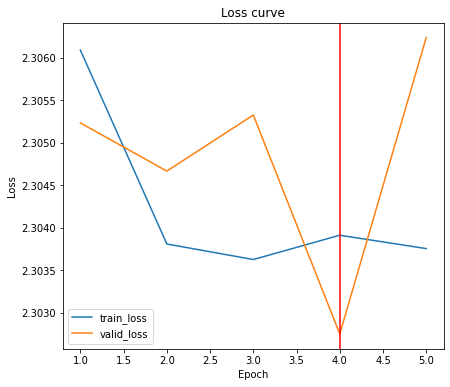

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

np_loss = np.array(valid_loss)
loss_ind_sorted = np.argsort(np_loss)
loss_min_ind = loss_ind_sorted[0]

x = [i+1 for i in range(len(train_loss))]

plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plt.title('Loss curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(x, train_loss, label='train_loss')
plt.plot(x, valid_loss, label='valid_loss')
plt.axvline(loss_min_ind+1, color='red')
plt.legend()

# 1-9 L2 (ridge) regularization method

In [ ]:
from matplotlib.patches import RegularPolygon
for i in range(0,3):
    model = CNN_1(1,10,8)
    print(model)
    
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = 1e-5)
    n_epochs = 5
    train_loss = [] # train loss per epoch
    valid_loss = [] # valid loss per epoch
    
    train_acc = [] # train accuracy per epoch
    valid_acc = [] # valid accuracy per epoch
    
    # update following two variables whenever valid accuracy improves
    best_model = copy.deepcopy(model)
    best_acc = 0
    
    for epoch in range(n_epochs):
        model.train() # set model as training mode(for compute gradient)
        train_total = 0
        train_correct = 0
        epoch_train_loss = 0
        
        for i, data in enumerate(train_loader):
            optimizer.zero_grad()
            
            inputs, labels = data[0], data[1]
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            loss = loss_function(outputs, labels)
            epoch_train_loss += loss.item()
            loss.backward() # compute gradient
            optimizer.step() # update weight & bias in the model with computed gradient
            
        train_loss.append(epoch_train_loss/len(train_loader))
        train_acc.append(train_correct/train_total)
        
        model.eval() # set model as evaluation mode
        with torch.no_grad():# we don't need to compute gradient during the evaluation process
            valid_total = 0
            valid_correct = 0
            epoch_valid_loss = 0
            for data in valid_loader:
                inputs, labels = data[0], data[1]
                outputs = model(inputs)
                
                _, predicted = torch.max(outputs.data, 1)
                valid_total += labels.size(0)
                valid_correct += (predicted == labels).sum().item()
                
                loss = loss_function(outputs, labels)
                epoch_valid_loss += loss.item()
            
            valid_loss.append(epoch_valid_loss/len(valid_loader))
            valid_acc.append(valid_correct / valid_total)
            
        print('[{}/{}]'.format(epoch+1, n_epochs))
        print('training loss : {:.3f}\t training accuracy : {:.3f}'.format(epoch_train_loss/len(train_loader), train_correct/train_total))
        print('validation loss : {:.3f}\t validation accuracy : {:.3f}'.format(epoch_valid_loss/len(valid_loader), valid_correct/valid_total))
        
        if valid_correct/valid_total > best_acc:
            print('validation accuracy improved {:.5f} ======> {:.5f}'.format(best_acc, valid_correct/valid_total))
            best_acc = valid_correct/valid_total
            best_model = copy.deepcopy(model)
    print("-----------------------------------------------------------------------------------------------------")

CNN_1(
  (conv1): Conv2d(1, 6, kernel_size=(8, 8), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(8, 8), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
[1/5]
training loss : 0.261	 training accuracy : 0.920
validation loss : 0.171	 validation accuracy : 0.953
validation accuracy improved 0.00000 ======> 0.95250
[2/5]
training loss : 0.143	 training accuracy : 0.962
validation loss : 0.137	 validation accuracy : 0.965
validation accuracy improved 0.95250 ======> 0.96492
[3/5]
training loss : 0.133	 training accuracy : 0.966
validation loss : 0.186	 validation accuracy : 0.956
[4/5]
training loss : 0.136	 training accuracy : 0.967
vali